![title](images/header.png)
# VI - Calculating areas of change and confidence intervals
-------
This notebook estimates of areas of change for all categories using the entire database of systematic points, and calculates the margin of error based on the visually interpreted data 
This script requires a m4 instance
###### For more information contact aurelie.shapiro@fao.org or remi.dannunzio@fao.org

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker

### 1 - Read files and set parameters
read the output merged file with the classification of all eSBAE points from script 5e

In [3]:
#GAB
#df = pd.read_csv('/home/sepal-user/module_results/esbae/GAB/GAB_esbae_supervised_class_1522.csv', low_memory=False)
#DRC
df = pd.read_csv('/home/sepal-user/module_results/esbae/DRC/DRC_esbae_supervised_class_1522.csv', low_memory=False)
#with provinces
#df = pd.read_csv('/home/sepal-user/module_results/esbae/DRC/DRC_esbae_supervised_class_1522_terr.csv', low_memory=False)
#COG
#df = pd.read_csv('/home/sepal-user/module_results/esbae/COG/COG_esbae_supervised_class_1522.csv', low_memory=False)
#CMR
#df = pd.read_csv('/home/sepal-user/module_results/esbae/CMR/CMR_esbae_supervised_class_1522.csv', low_memory=False)
#EQG
#df = pd.read_csv('/home/sepal-user/module_results/esbae/EQG/EQG_esbae_supervised_class_1522.csv', low_memory=False)
#CAR
#df = pd.read_csv('/home/sepal-user/module_results/esbae/CAR/CAR_esbae_supervised_class_1522.csv', low_memory=False)

In [10]:
pd.pivot_table(df,values='point_id',index=['Sim_CEO_Ref_Change_Year_1522'],columns=['stratum'],aggfunc="count")

stratum,1,2,3
Sim_CEO_Ref_Change_Year_1522,,,
Def2016,NaN,38.0,2316.0
Def2017,NaN,86.0,5198.0
Def2018,NaN,85.0,7027.0
Def2019,NaN,131.0,6980.0
Def2020,NaN,172.0,7908.0
Def2021,NaN,207.0,5908.0
Def2022,NaN,81.0,2200.0
Deg2016,NaN,160.0,103.0
Deg2017,NaN,110.0,173.0


In [5]:
#pd.pivot_table(df,values='point_id',index=['Province'],columns=['interpreted'],aggfunc="count")

In [6]:
print(df.columns.values)

['Unnamed: 0' 'images' 'mon_images' 'bfast_change_date' 'bfast_magnitude'
 'bfast_means' 'cusum_change_date' 'cusum_confidence' 'cusum_magnitude'
 'red_mean' 'red_sd' 'red_min' 'red_max' 'nir_mean' 'nir_sd' 'nir_min'
 'nir_max' 'swir1_mean' 'swir1_sd' 'swir1_min' 'swir1_max' 'swir2_mean'
 'swir2_sd' 'swir2_min' 'swir2_max' 'ndfi_mean' 'ndfi_sd' 'ndfi_min'
 'ndfi_max' 'brightness_mean' 'brightness_sd' 'brightness_min'
 'brightness_max' 'greenness_mean' 'greenness_sd' 'greenness_min'
 'greenness_max' 'wetness_mean' 'wetness_sd' 'wetness_min' 'wetness_max'
 'bs_slope_mean' 'bs_slope_sd' 'bs_slope_max' 'bs_slope_min'
 'ccdc_change_date' 'ccdc_magnitude' 'aspect' 'dw_class_mode'
 'dw_tree_prob__max' 'dw_tree_prob__min' 'dw_tree_prob__stdDev'
 'dw_tree_prob_mean' 'elevation' 'esa_lc20' 'esa_lc21' 'esri_lc17'
 'esri_lc18' 'esri_lc19' 'esri_lc20' 'esri_lc21' 'gfc_gain' 'gfc_loss'
 'gfc_lossyear' 'gfc_tc00' 'lang_tree_height' 'potapov_tree_height'
 'slope' 'tmf_2016' 'tmf_2017' 'tmf_2018' 'tmf_

In [11]:
print(len(df))

1973273


In [8]:
# use these strata counts for area estimation with Excel
strata_counts = df['stratum'].value_counts().sort_index()
print(strata_counts)

stratum
1    1037185
2     713253
3     222835
Name: count, dtype: int64


In [12]:
pd.pivot_table(df,values='point_id',index=['interpreted'],columns=['stratum'],aggfunc="count")

stratum,1,2,3
interpreted,,,
0,1036010,706163,219033
1,1175,7090,3802


In [13]:
def calculate_areas(db_total, strata_column, categories_column, interpretation_column, total_area, z_score):
    #total database all eSBAE points
    df_full = db_total.copy()
    # only CEO interpreted points
    df_interpreted = db_total[db_total[interpretation_column]==1]
    df_4calc       = db_total[~db_total[categories_column].isna()]
    
    # get all attributes
    categories = df_4calc[categories_column].unique()
    
    # get strata
    strata, d = df_4calc[strata_column].unique(), {}
    print(categories)
    # create stats for each entry
    for category in categories:
        
        if str(category) == 'nan':
            continue
            
        print(f' Calculating stats for {category}')
        # create binary class column
        df_4calc[category] =  df_4calc[categories_column].apply(lambda x: 1 if x == category else 0)
        df_interpreted[category] =  df_interpreted[categories_column].apply(lambda x: 1 if x == category else 0)
        
        print(f'We use {df_4calc[category].sum()} entries for area calculation of {category} in {categories_column}.')
        print(f'We use {df_interpreted[category].sum()} entries for margin of error calculation of {category} in {categories_column}.')
        
        # initialize variables for category <> check the catergories > def, deg, gain
        categories_area, se_total = 0, 0
        d2 = {}
        for stratum in strata:
                        
            if str(stratum) == 'nan':
                continue
            
            # subset to stratum
            df_stratum = df_full[df_full[strata_column] == stratum]
            
            # get area proportion for that stratum on full dataset
            proportion_strata = len(df_stratum)/len(df_full)

            # get stratum area (ha)
            stratum_area = proportion_strata * total_area

            # get proportion of forest change within strata from interpreted data
            proportion_category = len(
                df_4calc[(df_4calc[strata_column] == stratum) & (df_4calc[category] == 1)]
            ) / len(
                df_4calc[df_4calc[strata_column] == stratum]
            )
            
            # get area from proportion and full area
            category_stratum_area = proportion_category * stratum_area

            # get error from interpreted data for full stratum area
            # variance of binary class in single stratum
            var = np.var(df_interpreted[category][df_interpreted[strata_column] == stratum])
            sd = np.sqrt(var)  
            # number of interpreted points in the stratum
            n = len(df_interpreted[df_interpreted[strata_column] == stratum])
            se = sd/np.sqrt(n) * stratum_area
                          
            # add all stratum for totals
            categories_area += category_stratum_area
            se_total += se**2
            
            # add to dictionary
            d2[f'area_stratum_{stratum}'] = category_stratum_area
            d2[f'ci_stratum_{stratum}']=z_score*se
        
        d2['area_total'] = categories_area
        d2['MOE'] = z_score*np.sqrt(se_total)
        d2['MOE_perc'] =  d2['MOE'] / categories_area * 100
        d[category] = d2
    
    #pd.set_option('display.float_format', '{:.2f}'.format)
    # Format numbers with commas as thousand separators
    pd.options.display.float_format = '{:,.0f}'.format
    
    # Create the pivot table
    pivot_table = pd.pivot_table(df_full, values='point_id', index=[strata_column], columns=[categories_column], aggfunc="count", dropna=False)

    # Sort the index
    pivot_table = pivot_table.sort_index()
    print(pivot_table)
    # Print the sorted pivot table
    #print(pd.pivot_table(df_full,values='point_id',index=[strata_column],columns=[categories_column],aggfunc="count",dropna= False))
    
    return pd.DataFrame.from_dict(d, orient='index')

### Enter Parameters

###### country area (ha)
###### GAB = 26287600
###### DRC = 232798200
###### COG = 34402400
###### CMR = 46497000
###### EQG = 2685800
###### CAR = 62009300

#### options for categories_column
###### for CEO interpreted data only change types in each year: 'Ref_Change_Year_1522'
###### for CEO interpreted data only for all years: 'Ref_Change_Type_1522'
###### for all modeled points annual changes: 'Sim_CEO_Ref_Change_Year_1522'
###### for all modeled points all years: 'Sim_CEO_Ref_Change_Type_1522'

In [ ]:
#only for DRC list points by provinces
#provinces = df['Province'].value_counts().sort_index()
#print(provinces)

In [14]:
z_score = 1.647
db_total = df
#for DRC
#db_total= df[df['Province'] == 'Sud-Ubangi']
strata_column = 'stratum'
categories_column = 'Sim_CEO_Ref_Change_Year_1522' # select column based on above
interpretation_column = 'interpreted'
total_area = 26287600 #enter area from above
output_directory = '/home/sepal-user/module_results/esbae/GAB/'
file_prefix = 'DRC_annual'
index_name = 'ChangeYear' #for all years 'ChangeType' or 'ChangeYear' for annual data

In [15]:
stats_calc = calculate_areas(db_total, 
                strata_column, 
                categories_column, 
                interpretation_column,
                total_area,
                z_score)

stats_calc.index.name = index_name
stats_calc_sorted = stats_calc.sort_values(by=index_name, ascending=True)

# Set the float_format to prevent truncation in scientific notation
float_format_str = '{:.6f}'.format  # Adjust the precision as needed

total_out =  f'{output_directory}{file_prefix}_stats_2015_2022.csv'
# Export DataFrame to CSV without truncating data
stats_calc.to_csv(total_out,index=True,float_format=float_format_str)

stats_calc_sorted

['Stable' 'NF' 'Def2016' 'Def2018' 'Def2017' 'Def2019' 'Deg2018' 'Def2020'
 'Deg2020' 'Def2021' 'Deg2017' 'Def2022' 'Deg2019' 'Deg2016' 'Deg2022'
 'Deg2021']
 Calculating stats for Stable


/tmp/ipykernel_415/3651631007.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interpreted[category] =  df_interpreted[categories_column].apply(lambda x: 1 if x == category else 0)


We use 1007292 entries for area calculation of Stable in Sim_CEO_Ref_Change_Year_1522.
We use 4734 entries for margin of error calculation of Stable in Sim_CEO_Ref_Change_Year_1522.
 Calculating stats for NF


/tmp/ipykernel_415/3651631007.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interpreted[category] =  df_interpreted[categories_column].apply(lambda x: 1 if x == category else 0)


We use 924602 entries for area calculation of NF in Sim_CEO_Ref_Change_Year_1522.
We use 6302 entries for margin of error calculation of NF in Sim_CEO_Ref_Change_Year_1522.
 Calculating stats for Def2016


/tmp/ipykernel_415/3651631007.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interpreted[category] =  df_interpreted[categories_column].apply(lambda x: 1 if x == category else 0)


We use 2354 entries for area calculation of Def2016 in Sim_CEO_Ref_Change_Year_1522.
We use 72 entries for margin of error calculation of Def2016 in Sim_CEO_Ref_Change_Year_1522.
 Calculating stats for Def2018


/tmp/ipykernel_415/3651631007.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interpreted[category] =  df_interpreted[categories_column].apply(lambda x: 1 if x == category else 0)


We use 7112 entries for area calculation of Def2018 in Sim_CEO_Ref_Change_Year_1522.
We use 136 entries for margin of error calculation of Def2018 in Sim_CEO_Ref_Change_Year_1522.
 Calculating stats for Def2017


/tmp/ipykernel_415/3651631007.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interpreted[category] =  df_interpreted[categories_column].apply(lambda x: 1 if x == category else 0)


We use 5284 entries for area calculation of Def2017 in Sim_CEO_Ref_Change_Year_1522.
We use 118 entries for margin of error calculation of Def2017 in Sim_CEO_Ref_Change_Year_1522.
 Calculating stats for Def2019


/tmp/ipykernel_415/3651631007.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interpreted[category] =  df_interpreted[categories_column].apply(lambda x: 1 if x == category else 0)


We use 7111 entries for area calculation of Def2019 in Sim_CEO_Ref_Change_Year_1522.
We use 160 entries for margin of error calculation of Def2019 in Sim_CEO_Ref_Change_Year_1522.
 Calculating stats for Deg2018


/tmp/ipykernel_415/3651631007.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interpreted[category] =  df_interpreted[categories_column].apply(lambda x: 1 if x == category else 0)


We use 473 entries for area calculation of Deg2018 in Sim_CEO_Ref_Change_Year_1522.
We use 26 entries for margin of error calculation of Deg2018 in Sim_CEO_Ref_Change_Year_1522.
 Calculating stats for Def2020


/tmp/ipykernel_415/3651631007.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interpreted[category] =  df_interpreted[categories_column].apply(lambda x: 1 if x == category else 0)


We use 8080 entries for area calculation of Def2020 in Sim_CEO_Ref_Change_Year_1522.
We use 139 entries for margin of error calculation of Def2020 in Sim_CEO_Ref_Change_Year_1522.
 Calculating stats for Deg2020


/tmp/ipykernel_415/3651631007.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interpreted[category] =  df_interpreted[categories_column].apply(lambda x: 1 if x == category else 0)


We use 528 entries for area calculation of Deg2020 in Sim_CEO_Ref_Change_Year_1522.
We use 35 entries for margin of error calculation of Deg2020 in Sim_CEO_Ref_Change_Year_1522.
 Calculating stats for Def2021


/tmp/ipykernel_415/3651631007.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interpreted[category] =  df_interpreted[categories_column].apply(lambda x: 1 if x == category else 0)


We use 6115 entries for area calculation of Def2021 in Sim_CEO_Ref_Change_Year_1522.
We use 116 entries for margin of error calculation of Def2021 in Sim_CEO_Ref_Change_Year_1522.
 Calculating stats for Deg2017


/tmp/ipykernel_415/3651631007.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interpreted[category] =  df_interpreted[categories_column].apply(lambda x: 1 if x == category else 0)


We use 283 entries for area calculation of Deg2017 in Sim_CEO_Ref_Change_Year_1522.
We use 18 entries for margin of error calculation of Deg2017 in Sim_CEO_Ref_Change_Year_1522.
 Calculating stats for Def2022


/tmp/ipykernel_415/3651631007.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interpreted[category] =  df_interpreted[categories_column].apply(lambda x: 1 if x == category else 0)


We use 2281 entries for area calculation of Def2022 in Sim_CEO_Ref_Change_Year_1522.
We use 81 entries for margin of error calculation of Def2022 in Sim_CEO_Ref_Change_Year_1522.
 Calculating stats for Deg2019


/tmp/ipykernel_415/3651631007.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interpreted[category] =  df_interpreted[categories_column].apply(lambda x: 1 if x == category else 0)


We use 611 entries for area calculation of Deg2019 in Sim_CEO_Ref_Change_Year_1522.
We use 34 entries for margin of error calculation of Deg2019 in Sim_CEO_Ref_Change_Year_1522.
 Calculating stats for Deg2016


/tmp/ipykernel_415/3651631007.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interpreted[category] =  df_interpreted[categories_column].apply(lambda x: 1 if x == category else 0)


We use 263 entries for area calculation of Deg2016 in Sim_CEO_Ref_Change_Year_1522.
We use 53 entries for margin of error calculation of Deg2016 in Sim_CEO_Ref_Change_Year_1522.
 Calculating stats for Deg2022


/tmp/ipykernel_415/3651631007.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interpreted[category] =  df_interpreted[categories_column].apply(lambda x: 1 if x == category else 0)


We use 486 entries for area calculation of Deg2022 in Sim_CEO_Ref_Change_Year_1522.
We use 21 entries for margin of error calculation of Deg2022 in Sim_CEO_Ref_Change_Year_1522.
 Calculating stats for Deg2021


/tmp/ipykernel_415/3651631007.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interpreted[category] =  df_interpreted[categories_column].apply(lambda x: 1 if x == category else 0)


We use 398 entries for area calculation of Deg2021 in Sim_CEO_Ref_Change_Year_1522.
We use 22 entries for margin of error calculation of Deg2021 in Sim_CEO_Ref_Change_Year_1522.
Sim_CEO_Ref_Change_Year_1522  Def2016  Def2017  Def2018  Def2019  Def2020  \
stratum                                                                     
1                                 NaN      NaN      NaN      NaN      NaN   
2                                  38       86       85      131      172   
3                               2,316    5,198    7,027    6,980    7,908   

Sim_CEO_Ref_Change_Year_1522  Def2021  Def2022  Deg2016  Deg2017  Deg2018  \
stratum                                                                     
1                                 NaN      NaN      NaN      NaN      NaN   
2                                 207       81      160      110      122   
3                               5,908    2,200      103      173      351   

Sim_CEO_Ref_Change_Year_1522  Deg2019  Deg2020  De

,area_stratum_2,ci_stratum_2,area_stratum_3,ci_stratum_3,area_stratum_1,ci_stratum_1,area_total,MOE,MOE_perc
ChangeYear,,,,,,,,,
Def2016,506,"9,608","30,853","9,296",0,0,"31,360","13,370",43
Def2017,"1,146","11,447","69,247","12,120",0,0,"70,393","16,671",24
Def2018,"1,132","10,100","93,612","13,580",0,0,"94,745","16,924",18
Def2019,"1,745","12,263","92,986","14,356",0,0,"94,732","18,880",20
Def2020,"2,291","12,064","105,349","13,232",0,0,"107,640","17,906",17
Def2021,"2,758","11,862","78,705","11,857",0,0,"81,463","16,772",21
Def2022,"1,079","11,447","29,308","9,383",0,0,"30,387","14,801",49
Deg2016,"2,131","12,263","1,372","6,014",0,0,"3,504","13,658",390
Deg2017,"1,465","6,240","2,305","4,061",0,0,"3,770","7,445",197


### plot areas with error bars

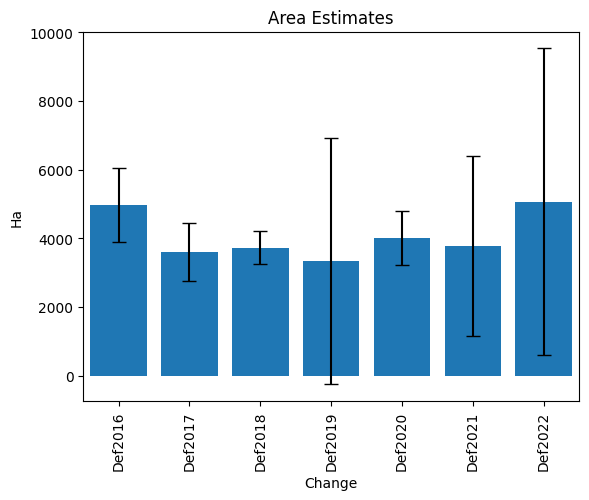

In [29]:
stats = pd.read_csv('/home/sepal-user/module_results/esbae/GAB/Gabon_annual_stats_2015_2022.csv', low_memory=False)
#select the values you want to plot
values_to_plot = ['Def2016','Def2017','Def2018','Def2019','Def2020','Def2021','Def2022']

# Filter the DataFrame to include only the selected values
Def_areas = stats[stats['ChangeYear'].isin(values_to_plot)]

# Create a bar chart
ax = Def_areas.plot(kind='bar', x='ChangeYear', y='area_total', legend=False)

# Format the y-axis labels with thousand separators (comma)
#ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{:,.0f}'))

# Add labels and a title
plt.xlabel('Change')
plt.ylabel('Ha')
plt.title('Area Estimates')
plt.bar(Def_areas['ChangeYear'], Def_areas['area_total'], yerr=Def_areas['MOE'], capsize=5)  # Add error bars

# Show the plot
plt.show()

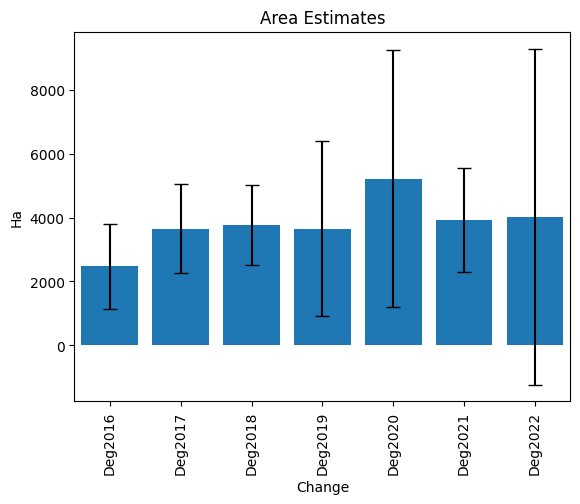

In [30]:
#plot DEG 
#select the values you want to plot
values_to_plot = ['Deg2016','Deg2017','Deg2018','Deg2019','Deg2020','Deg2021','Deg2022']

# Filter the DataFrame to include only the selected values
Deg_areas = stats[stats['ChangeYear'].isin(values_to_plot)]

# Create a bar chart
ax = Deg_areas.plot(kind='bar', x='ChangeYear', y='area_total', legend=False)

# Format the y-axis labels with thousand separators (comma)
#ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{:,.0f}'))

# Add labels and a title
plt.xlabel('Change')
plt.ylabel('Ha')
plt.title('Area Estimates')
plt.bar(Deg_areas['ChangeYear'], Deg_areas['area_total'], yerr=Deg_areas['MOE'], capsize=5)  # Add error bars
# Show the plot
plt.show()